In [1]:
# depth_plots.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from os import listdir, walk, getcwd
from os.path import isfile, join
import json

In [2]:
# parse metadata
filename = "data/Chest_xray_Corona_Metadata.csv"
df = pd.read_csv(filename, header=0)
df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [3]:
print("--- Dataset summary ---")
N = df.shape[0]
for sample_type in df.Dataset_type.unique().tolist():
    n_sample = df[(df.Dataset_type==sample_type)].shape[0]
    print("-> {:5s} ({:4}/{:4}={:2.2f}%)".format(sample_type,n_sample,N,100*n_sample/N))
    for label in df.Label.unique().tolist():
        print("--> {:8s} (N={})".format(label,df[(df.Label==label) & (df.Dataset_type==sample_type)].shape[0]))
        if (label=="Pnemonia"):
            for df.

SyntaxError: invalid syntax (<ipython-input-3-66558a086cdb>, line 9)

In [38]:
# scan images, summarize image sizes
from os import listdir, walk, getcwd
from os.path import isfile, join

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test","train"]
f=[]
all_reu=[]
i=0
for subpath in subpaths:
    for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
        for file in filenames:
            f.append("{}/{}/{}".format(path,subpath,file))
        break

## Scanning the images

- Problems:
    - Images have non-uniform sizes. Problematic since networks will need uniform input/output sizes.
    - Images have different dimensions:
        - Some are greyscale => img.shape = (rows, cols)
        - Some are RGB => img.shape = (rows, cols, RGB)

In [47]:
from skimage.io import imread

def shape_rgb_or_grey(img):
    """
        Report whether img is RGB or greyscale
    """
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

all_reu=[]
row_nums=[]
col_nums=[]
name_short=[]
data_type=[]
file_type=[]
color_list=[]
print("--- Parsing {} images ---".format(len(f)))
print_every = 500
i = 0

for filename in f:
    file_ext = filename.split(".")[-1]
    if ( file_ext in ["jpeg","jpg","png"]):
        if (i % print_every == 0):
            print("-> {} images parsed".format(i))
        img = imread(filename)
        try:
            rows, cols, color = shape_rgb_or_grey(img)
            row_nums.append(rows)
            col_nums.append(cols)
            name_short.append(filename.split("/")[-1])
            data_type.append(filename.split("/")[-2])
            file_type.append(file_ext)
            color_list.append(color)
            i += 1
        except ValueError:
            print(ValueError)
            print("{} - shape = {}".format(filename, img.shape))
        except:
            print("Unknown exception occurred.") 
        
    else:
        print("Skipping {}.".format(filename))
        
# summarize image sizes
data = {"name": name_short, "ext": file_type, "color": color_list, "split": data_type, "n_rows": row_nums, "n_cols": col_nums}
df_sizes = pd.DataFrame(data=data,columns=["name", "ext", "color", "split", "n_rows", "n_cols"])

df_sizes.describe()

--- Parsing 5933 images ---
-> 0 images parsed
-> 500 images parsed
-> 1000 images parsed
-> 1500 images parsed
-> 2000 images parsed
-> 2500 images parsed
-> 3000 images parsed
-> 3500 images parsed
-> 4000 images parsed
-> 4500 images parsed
-> 5000 images parsed
-> 5500 images parsed


,n_rows,n_cols
count,5933.000000,5933.000000
mean,973.030507,1327.163155
std,390.354003,375.229396
min,127.000000,255.000000
25%,688.000000,1056.000000
50%,888.000000,1280.000000
75%,1194.000000,1560.000000
max,3480.000000,4248.000000


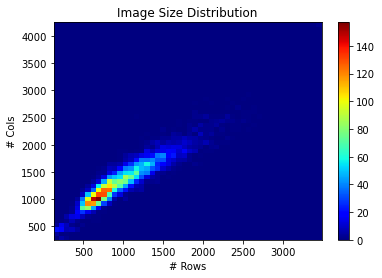

In [59]:
# visualize distribution of image sizes
import matplotlib.pyplot as plt
plt.hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Image Size Distribution")
plt.xlabel("# Rows")
plt.ylabel("# Cols")
plt.show()

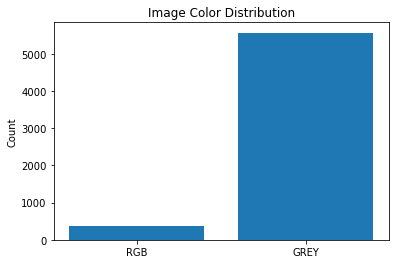

In [65]:
# visualize img colors
colors = ["RGB","GREY"]
vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
plt.bar(colors,vals)
plt.title("Image Color Distribution")
plt.ylabel("Count")
plt.show()

In [79]:
def plot_depth_tests(df,envir,ylabel="Test Loss [NMSE]"):
    save_bool = False
    plt.style.use(['science','ieee','muted'])
    df_target = df[(df["Envir"]==envir) & (df["Network"]=="LSTM Only")]
    n_tests, n_col = df_target.shape
    fig, ax = plt.subplots(figsize=(4,3))
    t_vals = [i for i in range(1,11)]
    t_labels = [r"$t_{{{:2d}}}$".format(i) for i in range(1,11)]
    for idx, row in df_target.iterrows():
        vals = [row["{}".format(i)] for i in range(1,11)]
        label = "Depth={}".format(row["Depth"])
        ax.plot(t_vals, vals, label=label)
    ax.set(ylabel=ylabel)
    ax.grid()
    ax.legend()
    plt.xticks(t_vals)
    ax.set_xticklabels(t_labels)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.15), ncol=3, fontsize="x-small")
    plt.show()
    fig_name="{}_depth_sweep.eps".format(envir,depth)
    fig.savefig(fig_name)